In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from cycler import cycler
import popoff
import pop_off_functions as pof
import pop_off_plotting as pop
from Session import SessionLite
from linear_model import PoolAcrossSessions, LinearModel, MultiSessionModel
from utils.utils_funcs import d_prime
from tqdm import tqdm
#import svgutils.compose as sc
import IPython.display as ip

/home/loidolt/RowlandEtAl/popping-off/popoff/popoff/loadpaths.py
/home/loidolt/RowlandEtAl/Vape


In [3]:
import seaborn as sns
from sklearn.decomposition import FactorAnalysis
from scipy.optimize import curve_fit

In [4]:
remove_targets = False
pas = PoolAcrossSessions(save_PCA=False, subsample_sessions=False,
                         remove_targets=remove_targets, remove_toosoon=True)
# print(pas.sessions)

## Create sessions object from PAS:
try:  # ensure sessions doesn't exist yet 
    sessions
    assert type(sessions) is dict
except NameError:
    pass

sessions = {}
int_keys_pas_sessions = pas.sessions.keys()
# print(int_keys_pas_sessions)
i_s = 0
for ses in pas.sessions.values():  # load into sessions dict (in case pas skips an int as key)
    ses.signature = f'{ses.mouse}_R{ses.run_number}'
    sessions[i_s] = ses
    i_s += 1
print(sessions)
assert len(sessions) == 11
pof.label_urh_arm(sessions=sessions)  # label arm and urh

long post time
long post time
long post time
long post time
long post time
Mouse RL070, run 29  registered no-lick hit. changed to too soon
long post time
long post time
Mouse RL117, run 29  registered no-lick hit. changed to too soon
Mouse RL117, run 29  registered no-lick hit. changed to too soon
long post time
long post time
long post time
Mouse RL116, run 32  registered no-lick hit. changed to too soon
Mouse RL116, run 32  registered no-lick hit. changed to too soon
Mouse RL116, run 32  registered no-lick hit. changed to too soon
long post time
ALERT SESSIONS NOT SUBSAMPLED
long post time
long post time
long post time
long post time
long post time
long post time
long post time
long post time
long post time
long post time
long post time
{0: instance Mouse J064, run 10 of Session class, 1: instance Mouse J064, run 11 of Session class, 2: instance Mouse J064, run 14 of Session class, 3: instance Mouse RL070, run 28 of Session class, 4: instance Mouse RL070, run 29 of Session class, 5:

In [5]:
### print metadata
n_neurons = [len(np.nonzero(pas.linear_models[session].session.s1_bool==True)[0]) for session in pas.sessions]
print(n_neurons)
print(np.mean(n_neurons), np.std(n_neurons), np.min(n_neurons))

n_hits = [len(np.nonzero(pas.linear_models[session].session.outcome=='hit')[0]) for session in pas.sessions]
print(n_hits)
print(np.mean(n_hits), np.std(n_hits))

n_miss = [len(np.nonzero(pas.linear_models[session].session.outcome=='miss')[0]) for session in pas.sessions]
print(n_miss)
print(np.mean(n_miss), np.std(n_miss))

print(min(n_hits), min(n_miss))


[319, 536, 631, 333, 399, 250, 280, 343, 309, 255, 267]
356.54545454545456 116.4945286552616 250
[66, 76, 101, 59, 95, 152, 98, 33, 87, 166, 77]
91.81818181818181 36.870333434935276
[16, 28, 26, 148, 58, 53, 37, 67, 21, 21, 51]
47.81818181818182 35.65189828381751
33 16


In [6]:
color_tt = {'hit': '#117733', 'miss': '#882255', 'fp': '#88CCEE', 'cr': '#DDCC77',
            'Hit': '#117733', 'Miss': '#882255', 'FP': '#88CCEE', 'CR': '#DDCC77',
            'urh': '#44AA99', 'arm': '#AA4499', 'spont': '#332288', 'prereward': '#332288', 
            'reward\nonly': '#332288', 'Reward\nonly': '#332288',
            'pre_reward': '#332288', 'Reward': '#332288', 'reward only': '#332288', 'rew. only': '#332288', 'hit&miss': 'k', 
            'fp&cr': 'k', 'photostim': sns.color_palette()[6], 'too_': 'grey',
            'hit_n1': '#b0eac9', 'hit_n2': '#5ab17f', 'hit_n3': '#117733',
            'miss_n1': '#a69098', 'miss_n2': '#985d76', 'miss_n3': '#882255',
            'hit_c1': '#b0eac9', 'hit_c2': '#5ab17f', 'hit_c3': '#117733',
            'miss_c1': '#a69098', 'miss_c2': '#985d76', 'miss_c3': '#882255'
            } 

In [7]:
import matplotlib
matplotlib.rcParams["xtick.labelsize"] = 10
matplotlib.rcParams["ytick.labelsize"] = 10
matplotlib.rcParams["axes.labelsize"] = 10
matplotlib.rcParams["axes.titlesize"]= 10
matplotlib.rcParams["legend.fontsize"] = 10
matplotlib.rcParams["legend.title_fontsize"] = 10

matplotlib.rcParams["axes.spines.right"] = True
matplotlib.rcParams["axes.spines.top"] = True
matplotlib.rcParams["axes.spines.left"] = True
matplotlib.rcParams["axes.spines.bottom"] = True

matplotlib.rcParams['axes.linewidth'] = 0.75
matplotlib.rcParams["axes.labelcolor"] = "black"
matplotlib.rcParams["axes.edgecolor"] = "black"
matplotlib.rcParams["xtick.color"] = "black"
matplotlib.rcParams["ytick.color"] = "black"

matplotlib.rcParams['xtick.major.size'] = 3
matplotlib.rcParams['xtick.major.width'] = 0.75
matplotlib.rcParams['xtick.minor.size'] = 3
matplotlib.rcParams['xtick.minor.width'] = 0.75

matplotlib.rcParams['ytick.major.size'] = 3
matplotlib.rcParams['ytick.major.width'] = 0.75
matplotlib.rcParams['ytick.minor.size'] = 3
matplotlib.rcParams['ytick.minor.width'] = 0.75

In [8]:
def _set_size(ax, w, h):
    """
        set the size of an axis, where the size describes the actual area of the plot,
        _excluding_ the axes, ticks, and labels.

        w, h: width, height in inches

        # Example
        ```
            cm = 2.54
            fig, ax = plt.subplots()
            ax.plot(stuff)
            fig.tight_layout()
            _set_size(ax, 3.5*cm, 4.5*cm)
        ```
    """
    # https://stackoverflow.com/questions/44970010/axes-class-set-explicitly-size-width-height-of-axes-in-given-units
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w) / (r - l)
    figh = float(h) / (t - b)
    ax.figure.set_size_inches(figw, figh)

In [9]:
print([pas.linear_models[i_session].session for i_session in range(11)])

[instance Mouse J064, run 10 of Session class, instance Mouse J064, run 11 of Session class, instance Mouse J064, run 14 of Session class, instance Mouse RL070, run 28 of Session class, instance Mouse RL070, run 29 of Session class, instance Mouse RL117, run 26 of Session class, instance Mouse RL117, run 29 of Session class, instance Mouse RL117, run 30 of Session class, instance Mouse RL123, run 22 of Session class, instance Mouse RL116, run 32 of Session class, instance Mouse RL116, run 33 of Session class]


In [10]:
pas.linear_models[0].flu.shape

(471, 162, 420)

In [11]:
n_session = 8
F = pas.linear_models[n_session].flu
F_rebinned = np.sum(F.reshape((F.shape[0], F.shape[1], F.shape[2]//3, 3)), axis=-1)

s1_idx = np.nonzero(pas.linear_models[n_session].session.s1_bool)[0]
s2_idx = np.nonzero(pas.linear_models[n_session].session.s2_bool)[0]
hit_idx = np.nonzero(pas.linear_models[n_session].session.outcome == 'hit')[0]
miss_idx = np.nonzero(pas.linear_models[n_session].session.outcome == 'miss')[0]

HitAndMiss_idx = np.sort(np.concatenate((hit_idx, miss_idx), axis=0))

print(HitAndMiss_idx.shape)

print(F.shape)
print(hit_idx.shape)
print(miss_idx.shape)

print(s1_idx.shape)

(108,)
(494, 177, 420)
(87,)
(21,)
(309,)


In [12]:
def ML_PrePost_dFF_plot(F_rebinned, neuron_idx, trial_idx, color,
                        F_min=-1, F_max=1,
                        stim_min=int(8*10-3), stim_max=int(8*10+10*0.75), 
                        ana_min=int(8*10-7*10), ana_max=int(8*10-0.5*10),
                        earliest_ana_start=int(8*10+3*10),
                        figsize=(1.8,1.325)):
    
    n_bins = int(F_rebinned.shape[2])
    
    fig, ax = plt.subplots(figsize=figsize, dpi=300)
    
    pre_F_rebinned = F_rebinned[neuron_idx][:,trial_idx][:,:,:stim_min]
    pre_X = np.arange(0, stim_min)
    pre_F_mean = np.mean(pre_F_rebinned, axis=(0,1))
    pre_F_std = np.std(np.mean(pre_F_rebinned, axis=0), axis=0)
    
    post_F_rebinned = F_rebinned[neuron_idx][:,trial_idx][:,:,stim_max:]
    post_X = np.arange(stim_max, n_bins)
    post_F_mean = np.mean(post_F_rebinned, axis=(0,1))
    post_F_std = np.std(np.mean(post_F_rebinned, axis=0), axis=0)
    
    ana_X = np.arange(ana_min, ana_max)
    ana_F_mean = np.mean(F_rebinned[neuron_idx][:,trial_idx][:,:,ana_min:ana_max])
    
    ax.plot(pre_X, pre_F_mean, color=color)
    ax.plot(post_X, post_F_mean, color=color)
    
    ax.fill_between(pre_X, pre_F_mean - pre_F_std, pre_F_mean+pre_F_std, alpha=0.4, color=color)
    ax.fill_between(post_X, post_F_mean - post_F_std, post_F_mean+post_F_std, alpha=0.4, color=color)
    
    ax.axvspan(xmin=stim_min+1, xmax=stim_max-2, alpha=1, color=color_tt['photostim'])
    
    ax.set_ylabel(r"$\Delta F/F$")
    ax.set_xlabel("time [s]")
    
    ax.set_xticks([8*10-5*10, 8*10, 8*10+5*10])
    ax.set_xticklabels([-5, 0, +5])
    ax.set_xlim(0,n_bins)
    
    ax.set_ylim(F_min, F_max)
    
    ax.fill_between(ana_X, pre_F_mean[ana_min:ana_max]+pre_F_std[ana_min:ana_max], F_max, alpha=0.3, color='grey')
    ax.fill_between(ana_X, F_min, pre_F_mean[ana_min:ana_max]-pre_F_std[ana_min:ana_max], alpha=0.3, color='grey')
    
    ax.axhline(ana_F_mean, color='k', linestyle=':')
    
    ax.axvline(ana_min, color='k', linestyle='-')
    ax.axvline(ana_max, color='k', linestyle='-')
    
    ax.axvline(earliest_ana_start, color='k', linestyle='--')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


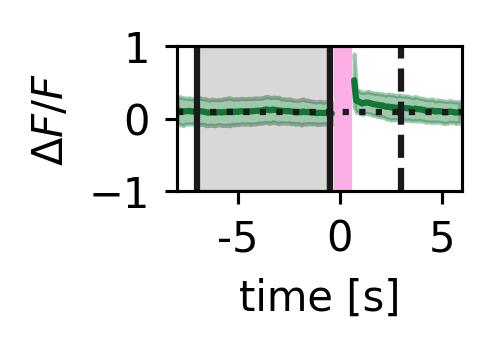

In [13]:
#Figure E10a
ML_PrePost_dFF_plot(F_rebinned, s1_idx, hit_idx, color=color_tt['hit'])
plt.tight_layout()
plt.savefig("../final_reports/FigureE10a.pdf")

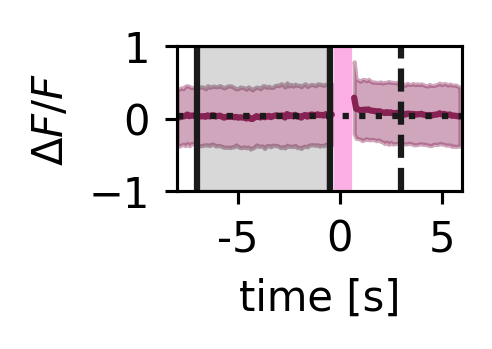

In [14]:
#Figure E10b
ML_PrePost_dFF_plot(F_rebinned, s1_idx, miss_idx, color=color_tt['miss'])
plt.tight_layout()
plt.savefig("../final_reports/FigureE10b.pdf")

In [15]:
pre_F_rebinned = F_rebinned[s1_idx][:,:,10:75]

pre_HitMiss_F_rebinned = F_rebinned[s1_idx][:,HitAndMiss_idx,:][:,:,10:75]

pre_F_concatenated = pre_F_rebinned.reshape((pre_F_rebinned.shape[0], pre_F_rebinned.shape[1]*pre_F_rebinned.shape[2]))

pre_HitMiss_F_concatenated = pre_HitMiss_F_rebinned.reshape((pre_HitMiss_F_rebinned.shape[0], pre_HitMiss_F_rebinned.shape[1]*pre_HitMiss_F_rebinned.shape[2]))

In [16]:
def ML_PreConcatenated_MatPlot(F):
    fig, ax = plt.subplots(figsize=(4,2.8), dpi=300)
    mats = ax.imshow(F,
                    aspect=10, cmap='gray_r', vmin=0, vmax=10)
    ax.set_xlabel("time [s]")
    ax.set_ylabel("neuron id")
    clb = fig.colorbar(mats, pad=0.1, shrink=0.325, aspect=10)
    clb.ax.set_title(r"$\Delta F/F$", fontsize=10)
    
    ax.set_xticklabels(ax.get_xticks()/10)

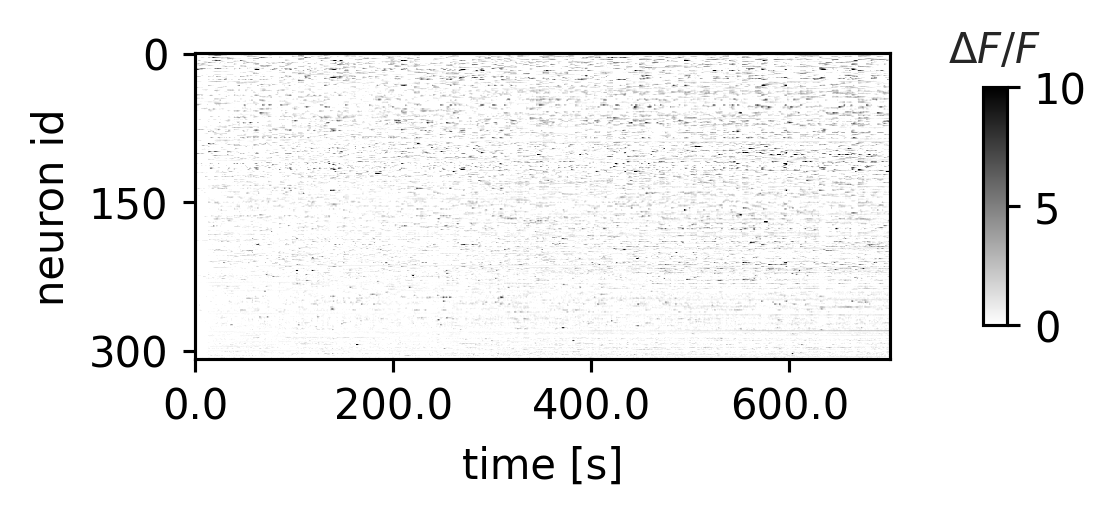

In [17]:
#Figure E10c
ML_PreConcatenated_MatPlot(pre_HitMiss_F_concatenated)
plt.yticks([0,150,300])
plt.tight_layout()
plt.savefig("../final_reports/FigureE10c.pdf")

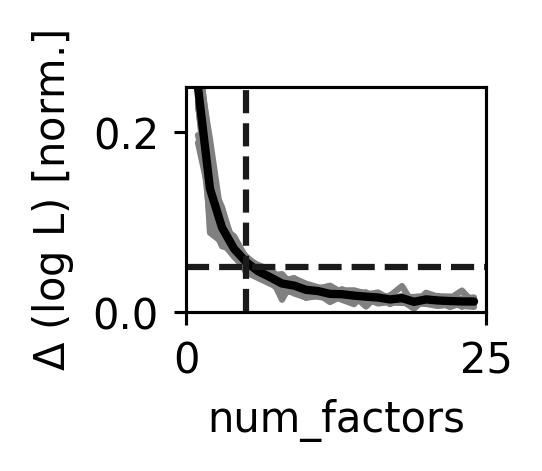

In [18]:
#Figure E10d
def log_likelihood_scan(F, factors):
    log_likes = np.zeros((len(factors),5))
    for i_f in range(len(factors)):
        random_timepoints = np.random.choice(np.arange(F.shape[1]), (5,int(F.shape[1]/5)), replace=False)
        for i_r in np.arange(5):
            transformer = FactorAnalysis(n_components=factors[i_f], random_state=0)
            training_timepoints = np.setdiff1d(np.arange(F.shape[1]), random_timepoints[i_r])
            testing_timepoints = random_timepoints[i_r]

            transformer.fit(F[:,training_timepoints].T)
            log_likes[i_f,i_r] = transformer.score(F[:,testing_timepoints].T)
    return factors, np.mean(log_likes, axis=1)

def Session_log_likelihood_scan(n_session, factors):
    F = pas.linear_models[n_session].flu
    F_rebinned = np.sum(F.reshape((F.shape[0], F.shape[1], F.shape[2]//3, 3)), axis=-1)

    s1_idx = np.nonzero(pas.linear_models[n_session].session.s1_bool)[0]
    s2_idx = np.nonzero(pas.linear_models[n_session].session.s2_bool)[0]
    hit_idx = np.nonzero(pas.linear_models[n_session].session.outcome == 'hit')[0]
    miss_idx = np.nonzero(pas.linear_models[n_session].session.outcome == 'miss')[0]
    
    HitAndMiss_idx = np.sort(np.concatenate((hit_idx, miss_idx), axis=0))
        
    pre_HitMiss_F_rebinned = F_rebinned[s1_idx][:,HitAndMiss_idx,:][:,:,10:75]
    pre_HitMiss_F_concatenated = pre_HitMiss_F_rebinned.reshape((pre_HitMiss_F_rebinned.shape[0], pre_HitMiss_F_rebinned.shape[1]*pre_HitMiss_F_rebinned.shape[2]))
    
    factors, log_likes = log_likelihood_scan(pre_HitMiss_F_concatenated, factors)
    
    return factors, log_likes

def MultiSession_log_likelihood_scan(factors):
    LOG_LIKES = np.zeros((11, len(factors)))
    FACTORS = np.zeros((11, len(factors)))
    for i_session in range(11):
        FACTORS[i_session], LOG_LIKES[i_session] = Session_log_likelihood_scan(i_session, factors)
    return FACTORS, LOG_LIKES

factors = np.arange(1,26).astype(int)
FACTORS, LOG_LIKES = MultiSession_log_likelihood_scan(factors)
fig, ax = plt.subplots(figsize=(1.25,1), dpi=300)
LOG_LIKES_normed = np.zeros_like(LOG_LIKES)

for i_session in range(11):
    LOG_LIKES_normed[i_session] = (LOG_LIKES[i_session]-min(LOG_LIKES[i_session]))/(max(LOG_LIKES[i_session])-min(LOG_LIKES[i_session]))
    plt.plot(FACTORS[i_session][:24], np.diff(LOG_LIKES_normed[i_session])[:24], 
             color='grey')

plt.plot(np.mean(FACTORS, axis=0)[:24], np.diff(np.mean(LOG_LIKES_normed, axis=0))[:24], 
          color='black', linewidth=2)
plt.axhline(0.05, color='k', linestyle='--')
plt.axvline(5, color='k', linestyle='--')
plt.xlim(0,25)
plt.xticks([0,25])
plt.ylim(0,0.25)
plt.xlabel("num_factors")
plt.ylabel(r"$\Delta$" +" (log L) [norm.]")

_set_size(ax, 1, 0.75)
plt.savefig("../final_reports/FigureE10d.pdf", dpi=300)

(319,)
(536,)
(631,)
(333,)
(399,)
(250,)
(280,)
(343,)
(309,)
(255,)
(267,)
(11, 25)


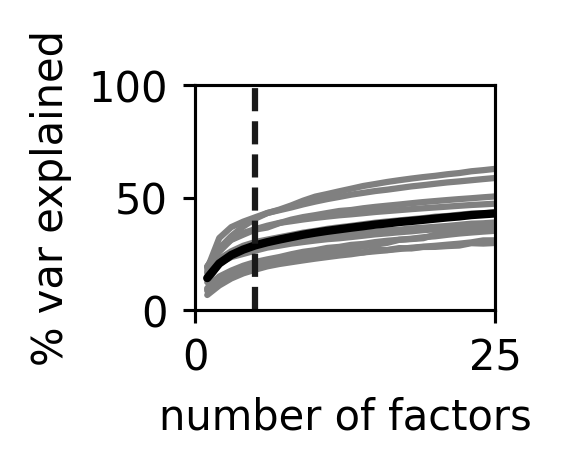

In [19]:
#Figure E10e
def ML_LFA_FacScan(F, factors):
    n_factors = len(factors)
    shared_var_exps = np.zeros(n_factors)
    individual_var_exps = np.zeros(n_factors)

    for i_f, factor in enumerate(factors):
        np.random.seed()
        transformer = FactorAnalysis(n_components=factor, random_state=0)
        S_transformed = transformer.fit_transform(F.T)

        n_rows = transformer.components_.shape[0]

        shared_variance = np.sum(transformer.components_**2, axis=1)

        shared_var_exps[i_f] = np.sum(shared_variance)

        individual_var_exps[i_f] = np.sum(transformer.noise_variance_)
        
    per_var_explained = shared_var_exps/(shared_var_exps+individual_var_exps)*100
    
    return factors, per_var_explained

def MultiSession_LFA_FacScan(factors):
    VAR_EXP = np.zeros((11,len(factors)))
    for n_session in range(11):
        F = pas.linear_models[n_session].flu
        F_rebinned = np.sum(F.reshape((F.shape[0], F.shape[1], F.shape[2]//3, 3)), axis=-1)

        s1_idx = np.nonzero(pas.linear_models[n_session].session.s1_bool)[0]
        print(s1_idx.shape)
        s2_idx = np.nonzero(pas.linear_models[n_session].session.s2_bool)[0]
        hit_idx = np.nonzero(pas.linear_models[n_session].session.outcome == 'hit')[0]
        miss_idx = np.nonzero(pas.linear_models[n_session].session.outcome == 'miss')[0]
        
        HitAndMiss_idx = np.sort(np.concatenate((hit_idx, miss_idx), axis=0))
        
        pre_HitMiss_F_rebinned = F_rebinned[s1_idx][:,HitAndMiss_idx,:][:,:,10:75]
        pre_HitMiss_F_concatenated = pre_HitMiss_F_rebinned.reshape((pre_HitMiss_F_rebinned.shape[0], pre_HitMiss_F_rebinned.shape[1]*pre_HitMiss_F_rebinned.shape[2]))
        
        factors, per_var_explained = ML_LFA_FacScan(pre_HitMiss_F_concatenated, factors)
        
        VAR_EXP[n_session] = per_var_explained
    return factors, VAR_EXP

factors = np.arange(1,26).astype(int)
factors, VAR_EXP = MultiSession_LFA_FacScan(factors)
print(VAR_EXP.shape)

def MutiSession_Plot_LFA_FacScan(factors, VAR_EXP, n_fact):
    fig, ax = plt.subplots(dpi=300)
    
    for i_session in range(VAR_EXP.shape[0]):
        ax.plot(factors, VAR_EXP[i_session], color='grey')
    ax.plot(factors, np.mean(VAR_EXP, axis=0), color='black', linewidth=2)
    
    ax.axvline(n_fact, color='k', linestyle='--')
    
    ax.set_xlabel("number of factors")
    ax.set_ylabel("% var explained")
    ax.set_ylim(0,100)
    ax.set_xlim(0,factors[-1])
    ax.set_xticks([0,factors[-1]])
    ax.set_yticks([0,50,100])
    
    _set_size(ax, 1, 0.75)
    plt.savefig("../final_reports/FigureE10e.pdf", dpi=300)

MutiSession_Plot_LFA_FacScan(factors, VAR_EXP, n_fact=5)

In [20]:
#do LFA
transformer = FactorAnalysis(n_components=5)
pre_F_factors = transformer.fit_transform(pre_HitMiss_F_concatenated.T)
pre_F_shared = np.dot(pre_F_factors,transformer.components_).T
pre_F_nonshared = pre_HitMiss_F_concatenated - pre_F_shared

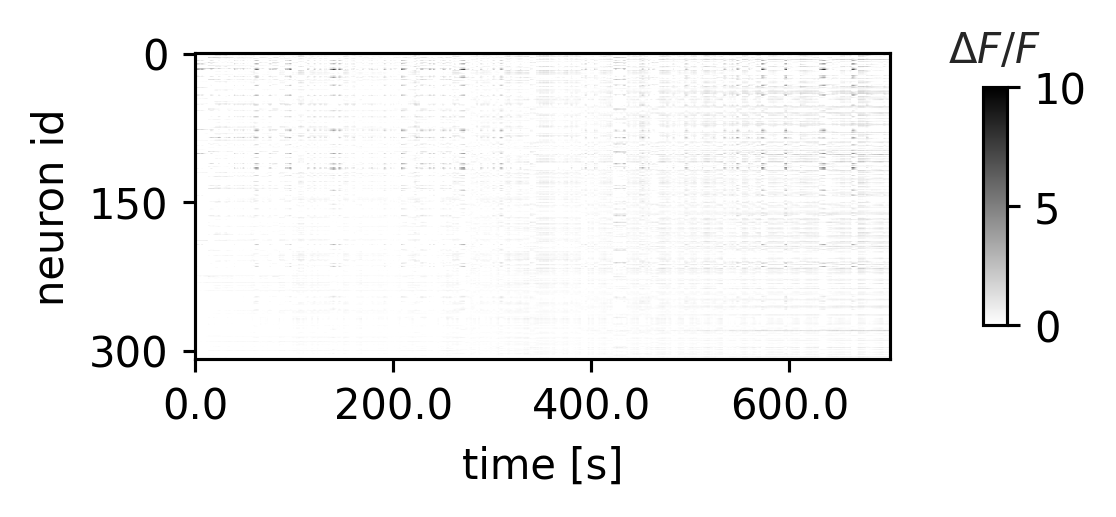

In [21]:
#FigureE10f
ML_PreConcatenated_MatPlot(pre_F_shared)
plt.yticks([0,150,300])
plt.tight_layout()
plt.savefig("../final_reports/FigureE10f.pdf")

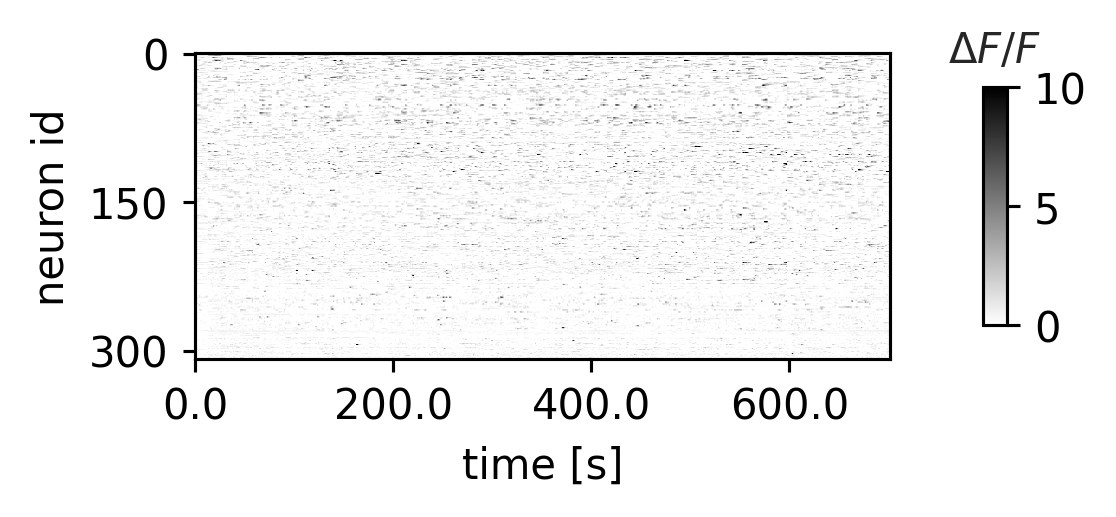

In [22]:
#FigureE10g
ML_PreConcatenated_MatPlot(pre_F_nonshared)
plt.yticks([0,150,300])
plt.tight_layout()
plt.savefig("../final_reports/FigureE10g.pdf")

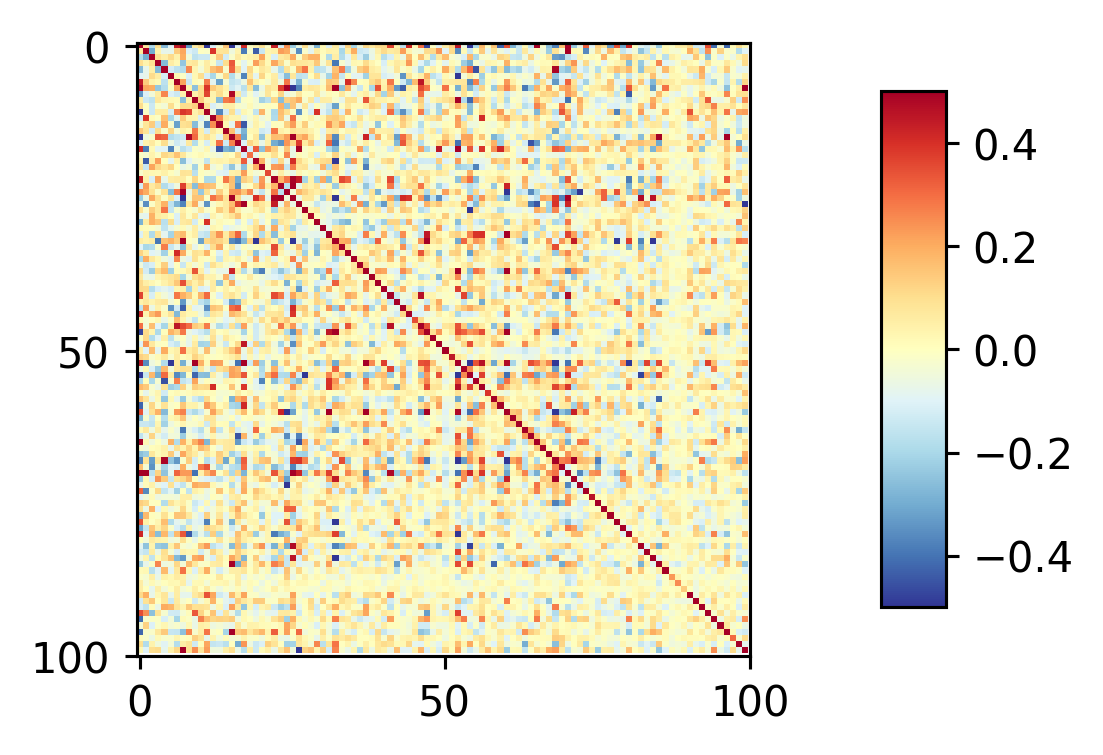

In [23]:
#FigureE10h
def ML_CovMat_BigPlot(F, n_neurons=100, vmin=-0.5, vmax=0.5, TvdP_norm=False, figsize=(2.25,2)):
    
    C = np.cov(F)
    if TvdP_norm:
        a_bar = np.mean(C[np.eye(C.shape[0],dtype=bool)])
        C = C / a_bar
    
    fig,ax = plt.subplots(figsize=figsize, dpi=300)
    mats = ax.imshow(C[:n_neurons,:n_neurons], cmap='RdYlBu_r', vmin=vmin, vmax=vmax)
    cb = plt.colorbar(mats, shrink=0.5, pad=0.15, aspect=8)
    
    ax.set_xticks([0,n_neurons/2,n_neurons])
    ax.set_yticks([0,n_neurons/2,n_neurons])

ML_CovMat_BigPlot(pre_F_nonshared, vmin=-0.5, vmax=0.5, figsize=(3.8,3.8))
plt.tight_layout()
plt.savefig("../final_reports/FigureE10h.pdf")

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


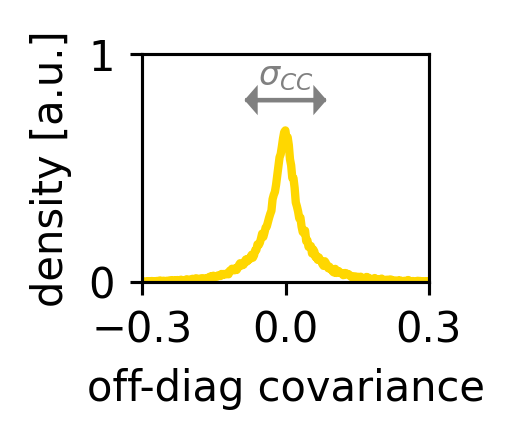

In [24]:
#FigureE10i
def ML_CovDist_OffDiagPlot(F, vmin=-0.3, vmax=0.3, TvdP_norm=False):
    
    C = np.cov(F)
    if TvdP_norm:
        a_bar = np.mean(C[np.eye(C.shape[0],dtype=bool)])
        C = C / a_bar
    
    off_diag = C[~np.eye(C.shape[0],dtype=bool)].ravel()
    off_X = np.linspace(np.min(off_diag), np.max(off_diag), 1000)
    off_Hist, _ = np.histogram(off_diag, off_X, density=True)
    
    dc = np.std(off_diag)
    
    fig, ax = plt.subplots(figsize=(1.8,1.6), dpi=300)
    plt.plot(off_X[:-1], off_Hist, linewidth=2, color='gold')
    
    plt.arrow(-dc, np.max(off_Hist)*1.2, 2*dc, 0, 
              color='grey', head_length=0.0175, head_width=1.5, length_includes_head = True)
    plt.arrow(dc, np.max(off_Hist)*1.2, -2*dc, 0, 
              color='grey', head_length=0.0175, head_width=1.5, length_includes_head = True)
    
    ax.text(0, np.max(off_Hist)*1.3, r"$\sigma_{CC}$", horizontalalignment='center', fontsize=8, color='grey')
    
    ax.set_xlim([vmin, vmax])
    ax.set_ylim([0,np.max(off_Hist*1.5)])
    
    ax.set_xticks([vmin,0,vmax])
    ax.set_yticks([0,np.max(off_Hist*1.5)])
    ax.set_yticklabels([0,1])
    
    plt.ylabel('density [a.u.]')
    #plt.xlabel('cross-covariance \n' + r"($c_{ij, j \neq i}$)")
    plt.xlabel('off-diag covariance')

ML_CovDist_OffDiagPlot(pre_F_nonshared)
plt.tight_layout()
plt.savefig("../final_reports/FigureE10i.pdf")

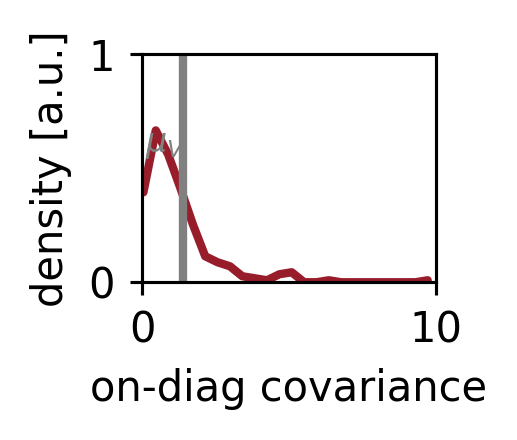

In [25]:
#FigureE10j
def ML_CovDist_OnDiagPlot(F, vmin=0, vmax=10, TvdP_norm=False):
    
    C = np.cov(F)
    if TvdP_norm:
        a_bar = np.mean(C[np.eye(C.shape[0],dtype=bool)])
        C = C / a_bar
    
    on_diag = C[np.eye(C.shape[0],dtype=bool)].ravel()
    on_X = np.linspace(np.min(on_diag), np.max(on_diag), 25)
    on_Hist, _ = np.histogram(on_diag, on_X, density=True)
    
    mu = np.mean(on_diag)
    
    fig, ax = plt.subplots(figsize=(1.8,1.6), dpi=300)
    plt.plot(on_X[:-1], on_Hist, linewidth=2, color=(152/255,29/255,43/255))
    
    plt.axvline(mu, linewidth=2, color='grey')
    
    ax.text(np.mean(on_Hist), 0.5, r"$\mu_{V}$", 
            horizontalalignment='left', fontsize=8, color='grey')
    
    ax.set_xlim([0,vmax])
    ax.set_ylim([0,np.max(on_Hist*1.5)])
    
    ax.set_xticks([0,vmax])
    ax.set_yticks([0,np.max(on_Hist*1.5)])
    ax.set_yticklabels([0,1])
    
    plt.ylabel('density [a.u.]')
    #plt.xlabel('cross-covariance \n' + r"($c_{ij, j \neq i}$)")
    plt.xlabel('on-diag covariance')

ML_CovDist_OnDiagPlot(pre_F_nonshared)
plt.tight_layout()
plt.savefig("../final_reports/FigureE10j.pdf")

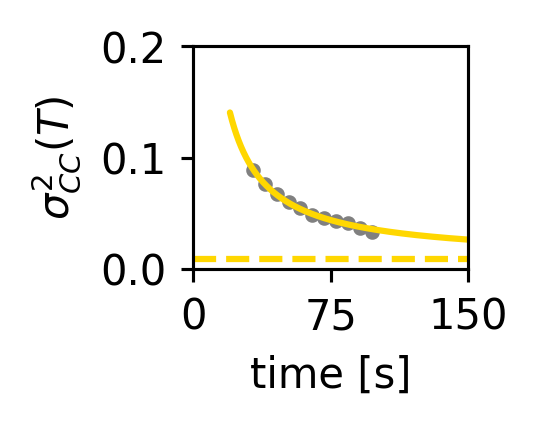

In [26]:
#FigureE10k
def ML_MuSigma_CalcSubsampling(F, TvdP_norm=False, trial_structure=True, n_realizations=50):
    C = np.cov(F)
    if TvdP_norm:
        a_bar = np.mean(C[np.eye(C.shape[0],dtype=bool)])
        C = C / a_bar
    
    mean_cii = np.mean(C[np.eye(C.shape[0],dtype=bool)])
    
    if trial_structure:
        n_trials = np.arange(5,16)
        n_timepoints = np.arange(5*65,16*65, 65)
        std_cij_RT = np.zeros((n_trials.shape[0], n_realizations))
        mu_cii_RT = np.zeros((n_trials.shape[0], n_realizations))
        
        for i_t in range(n_trials.shape[0]):
            for i_r in range(n_realizations):
                random_trials = np.random.choice(F.shape[1]//(int(6.5*10)), n_trials[i_t], replace=False)
                random_timepoints = [np.arange(i_trial*65,(i_trial+1)*(int(6.5*10))) for i_trial in random_trials]
                
                C_RT = np.cov(F[:,random_timepoints].reshape((F.shape[0], len(random_timepoints)*65)))
                if TvdP_norm:
                    a_bar = np.mean(C_RT[np.eye(C_RT.shape[0],dtype=bool)])
                    C_RT = C_RT / a_bar
                std_cij_RT[i_t,i_r] = np.std(C_RT[~np.eye(C_RT.shape[0],dtype=bool)].ravel())
                mu_cii_RT[i_t,i_r] = np.std(C_RT[np.eye(C_RT.shape[0],dtype=bool)].ravel())
                
    else:
        n_timepoints = np.arange(5*65,16*65, 65)
        std_cij_intrinsic_RT = np.zeros((n_trials.shape[0], n_realizations))
        mu_cii_RT = np.zeros((n_trials.shape[0], n_realizations))
        
        for i_t in range(n_trials.shape[0]):
            for i_r in range(n_realizations):
                random_timepoints = np.random.choice(F.shape[1], n_trials[i_t], replace=False)
                
                C_RT = np.cov(F[:,random_timepoints].reshape((F.shape[0], len(random_timepoints)*65)))
                if TvdP_norm:
                    a_bar = np.mean(C_RT[np.eye(C_RT.shape[0],dtype=bool)])
                    C_RT = C_RT / a_bar
                std_cij_RT[i_t,i_r] = np.std(C_RT[~np.eye(C_RT.shape[0],dtype=bool)].ravel())
                mu_cii_RT[i_t,i_r] = np.std(C_RT[np.eye(C_RT.shape[0],dtype=bool)].ravel())
        
    inv_func = lambda T, a, dc : dc**2 + a/T
    popt, pcov = curve_fit(f=inv_func, 
                           xdata=n_timepoints, 
                           ydata=np.mean(std_cij_RT**2, axis=-1))

    # get asymptotic standard deviation of the cross-covariances
    std_cij_inf = popt[1]

    s = std_cij_inf / mean_cii
    R = np.sqrt(1-np.sqrt(1/(1+100000 * s**2)))
    return (n_timepoints, np.mean(std_cij_RT**2, axis=-1), np.mean(mu_cii_RT, axis=-1), mean_cii, std_cij_inf, popt)

(xdata, sigma_squared, mu, mean_cii, std_cij_inf, popt) = ML_MuSigma_CalcSubsampling(pre_F_nonshared, TvdP_norm=False)

def ML_Sigma_PlotSubsampling(xdata, ydata, popt, xmin=False, xmax=False):
    inv_func = lambda T, a, dc : dc**2 + a/T
    
    if not xmin:
        xmin = min(xdata)
    if not xmax:
        xmax = max(xdata)
    
    xspace = np.linspace(200, 1500, 1000)
    
    fig, ax = plt.subplots(figsize=(3/2.54,2.5/2.54), dpi=300)
    
    ax.plot(xdata, ydata, linestyle='', marker='.', color='grey', markersize=5)
    ax.plot(xspace, inv_func(xspace, *popt), color='gold')
    
    ax.axhline(popt[1]**2, color='gold', linestyle='--')
    
    ax.set_ylim([0, 0.2])
    ax.set_ylabel(r"$\sigma_{CC}^{2}(T)$")
    
    #ax.set_xticklabels(np.array(ax.get_xticks()/10).astype(int))
    ax.set_xticks([0,750,1500])
    ax.set_xticklabels([0,75,150])
    ax.set_xlim(0,1500)
    ax.set_xlabel("time [s]")

ML_Sigma_PlotSubsampling(xdata, sigma_squared, popt, xmin=0, xmax=1500)
plt.savefig("../final_reports/FigureE10k.pdf")

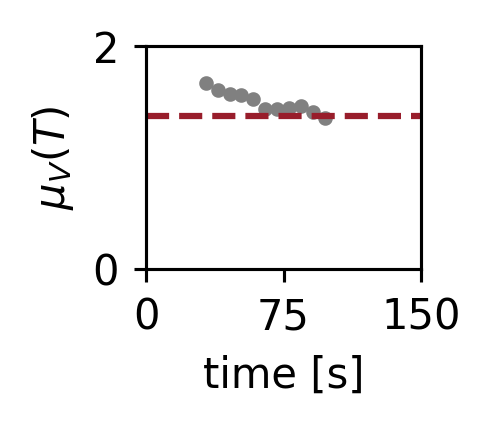

In [27]:
#FigureE10i
def ML_Mu_PlotSubsampling(xdata, ydata, mean_cii, xmin=False, xmax=False):
    inv_func = lambda T, a, dc : dc**2 + a/T
    
    if not xmin:
        xmin = min(xdata)
    if not xmax:
        xmax = max(xdata)
    
    xspace = np.linspace(xmin, xmax, 1000)
    
    fig, ax = plt.subplots(figsize=(3/2.54,2.5/2.54), dpi=300)
    
    ax.plot(xdata, ydata, linestyle='', marker='.', color='grey', markersize=5)
    
    ax.axhline(mean_cii, color=(152/255,29/255,43/255), linestyle='--')
    
    ax.set_ylim([0, 1.2*np.max(mu)])
    ax.set_ylabel(r"$\mu_{V}(T)$")
    
    ax.set_xticks([0,750,1500])
    ax.set_xticklabels([0,75,150])
    ax.set_xlim(0,1500)
    ax.set_xlabel("time [s]")

ML_Mu_PlotSubsampling(xdata, mu, mean_cii)
plt.savefig("../final_reports/FigureE10i.pdf")